In [ ]:
'''
This script fits single events

In [1]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from mpl_toolkits.mplot3d import Axes3D
import yaml
import scipy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']

In [157]:
#Good events for run_0102 are: 689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 6587, 3578, 745, 430
full = h5py.File('/home/chen/Real Data/clean_run_0102.h5', 'r')
evt_ID = 745
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 150.0:
        del_list.append(i)
cut_xyzs = np.delete(xyzs,del_list,axis=0)

In [158]:
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

In [159]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_values = uvw.values

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
cut_uvw_values = cut_uvw.values

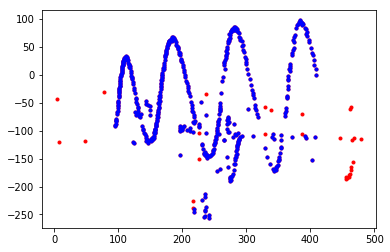

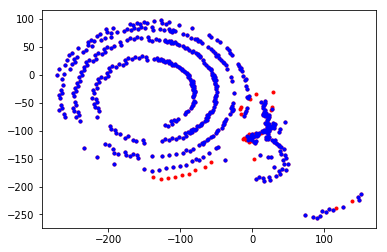

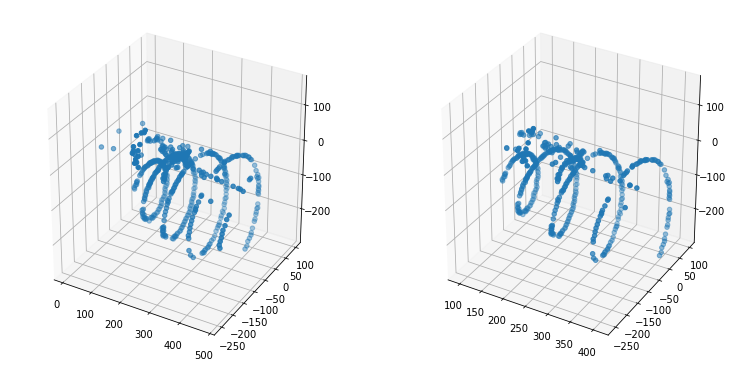

In [160]:
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0])
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0])

In [161]:
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

In [162]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [163]:
minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)

In [164]:
#define objective function
def f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def jacobian(x):
    return scipy.optimize.approx_fprime(x,f,eps)

In [165]:

def cut_f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def cut_jacobian(x):
    return scipy.optimize.approx_fprime(x,cut_f,eps)

In [166]:
i = 1
def callbackF(x):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1   

In [167]:
j = 1    
def cut_callbackF(x):
    global j
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
    j += 1  

**Conjugate Gradient**

In [168]:
cg_results = scipy.optimize.minimize(f, ctr0, jac=jacobian, method="CG", callback=callbackF)
cg = cg_results.x
print(cg_results)

   1 0.009507 0.004644 0.676735 2.464520-2.050111 1.787132 95.793164
   2 0.009054 0.004400 0.674907 2.464544-2.050152 1.788128 95.518199
   3 0.000365-0.001484 0.673185 2.464509-2.050703 1.792290 94.086145
   4 0.000290-0.002374 0.673127 2.464532-2.050757 1.794795 93.829857
   5 0.003396-0.005066 0.687088 2.464330-2.050375 1.806826 92.423291
   6 0.010678-0.006666 0.714461 2.464105-2.049701 1.839234 87.082823
   7 0.011441-0.006395 0.719030 2.464096-2.049609 1.845226 86.783666
   8 0.007828-0.000272 0.726230 2.464435-2.049496 1.865482 80.166485
   9 0.000756 0.003098 0.729645 2.464501-2.049601 1.866850 77.139853
  10-0.008412 0.006545 0.729957 2.469340-2.049610 1.870078 76.679371
  11-0.007877 0.006108 0.729094 2.469546-2.049609 1.870832 76.386950
  12-0.005979 0.005072 0.729504 2.469719-2.049736 1.870844 75.874864
  13-0.004947 0.004503 0.729374 2.469906-2.049874 1.871195 75.759680
  14-0.004121 0.004083 0.729868 2.470084-2.050054 1.871090 75.680293
     fun: 75.68029250503984
     j

In [169]:
cut_cg_results = scipy.optimize.minimize(cut_f, cut_ctr0, jac=cut_jacobian, method="CG", callback=cut_callbackF)
cut_cg = cut_cg_results.x
print(cut_cg_results)

   1 0.010038 0.003022 0.675508 2.377409-2.049902 1.793252 95.230111
   2 0.008424 0.002585 0.673623 2.377414-2.050003 1.794322 95.024766
   3 0.003039-0.000087 0.675837 2.377328-2.050206 1.794783 94.040075
   4-0.000846-0.001342 0.676068 2.377381-2.050707 1.799467 93.590308
   5 0.002006-0.001074 0.677222 2.377425-2.051090 1.803738 92.962026
   6 0.003779-0.003874 0.684847 2.377381-2.051216 1.809094 92.059103
   7 0.008129-0.005236 0.701216 2.377465-2.051894 1.826960 91.477511
   8 0.011526-0.004957 0.715384 2.377679-2.052636 1.846472 87.524522
   9 0.009378-0.001197 0.722171 2.378090-2.053253 1.861706 82.163079
  10-0.003786 0.005210 0.720625 2.378463-2.053535 1.862467 78.445334
  11-0.004283 0.005213 0.721256 2.378503-2.053594 1.862408 78.345720
  12-0.004452 0.005133 0.721659 2.378827-2.053633 1.862395 78.171361
  13-0.002021 0.003146 0.721598 2.379085-2.053803 1.863901 77.896023
  14-0.001464 0.002572 0.722424 2.379197-2.053920 1.864192 77.693727
  15-0.001753 0.002898 0.722899 2.

In [170]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(cg[0], cg[1], cg[2], cg[3], cg[4], cg[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_cg[0], cut_cg[1], cut_cg[2], cut_cg[3], cut_cg[4], cut_cg[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


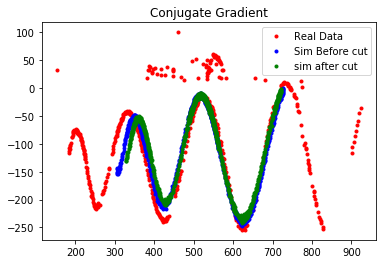

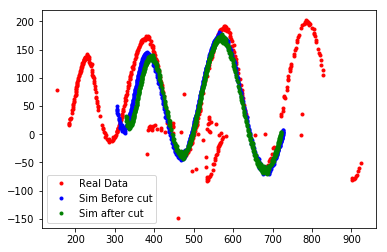

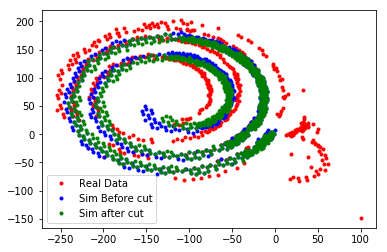

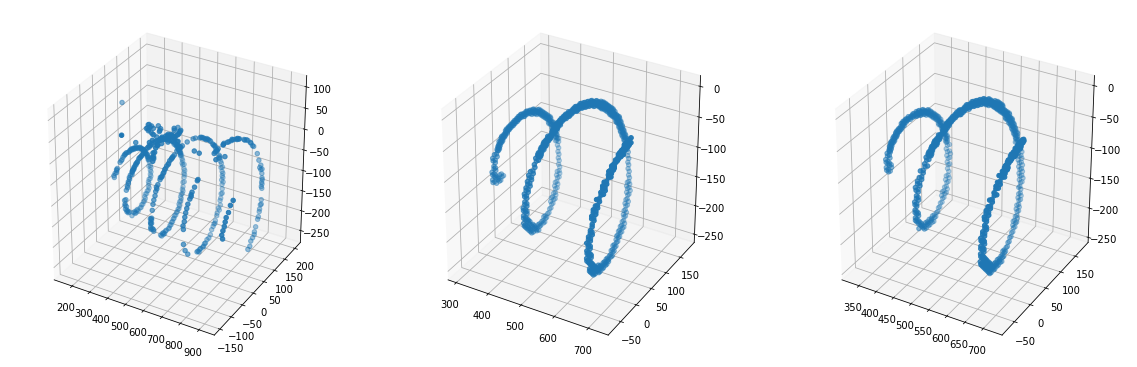

In [171]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.title("Conjugate Gradient")
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

**Nelder-Mead**

In [172]:
nm_results = scipy.optimize.minimize(f, ctr0, method="Nelder-Mead", callback=callbackF)
nm = nm_results.x
print(nm_results)

  15 0.000000 0.000000 0.720424 2.464555-2.050225 1.870902 88.203612
  16 0.000000 0.000000 0.720424 2.464555-2.050225 1.870902 88.203612
  17 0.000148 0.000148 0.704414 2.373275-2.031241 1.834606 87.573268
  18 0.000148 0.000148 0.704414 2.373275-2.031241 1.834606 87.573268
  19 0.000148 0.000148 0.704414 2.373275-2.031241 1.834606 87.573268
  20 0.000148 0.000148 0.704414 2.373275-2.031241 1.834606 87.573268
  21 0.000148 0.000148 0.704414 2.373275-2.031241 1.834606 87.573268
  22 0.000148 0.000148 0.704414 2.373275-2.031241 1.834606 87.573268
  23 0.000148 0.000148 0.704414 2.373275-2.031241 1.834606 87.573268
  24 0.000148 0.000148 0.704414 2.373275-2.031241 1.834606 87.573268
  25 0.000114 0.000112 0.706954 2.459899-2.023041 1.839224 86.769871
  26 0.000073 0.000068 0.707955 2.384201-2.119264 1.844584 81.622675
  27 0.000073 0.000068 0.707955 2.384201-2.119264 1.844584 81.622675
  28 0.000073 0.000068 0.707955 2.384201-2.119264 1.844584 81.622675
  29 0.000091 0.000086 0.721564 2.

 137-0.000312-0.000321 0.746896 3.019687-2.100706 1.850326 42.504429
 138-0.000312-0.000321 0.746896 3.019687-2.100706 1.850326 42.504429
 139-0.000312-0.000321 0.746896 3.019687-2.100706 1.850326 42.504429
 140-0.000312-0.000321 0.746896 3.019687-2.100706 1.850326 42.504429
 141-0.000312-0.000321 0.746896 3.019687-2.100706 1.850326 42.504429
 142-0.000312-0.000321 0.746896 3.019687-2.100706 1.850326 42.504429
 143-0.000312-0.000321 0.746897 3.020223-2.100581 1.850257 42.503608
 144-0.000312-0.000321 0.746885 3.019744-2.100777 1.850318 42.501511
 145-0.000312-0.000321 0.746885 3.019744-2.100777 1.850318 42.501511
 146-0.000311-0.000320 0.746790 3.018452-2.101365 1.850347 42.492365
 147-0.000311-0.000320 0.746790 3.018452-2.101365 1.850347 42.492365
 148-0.000311-0.000320 0.746790 3.018452-2.101365 1.850347 42.492365
 149-0.000311-0.000320 0.746790 3.018452-2.101365 1.850347 42.492365
 150-0.000311-0.000320 0.746790 3.018452-2.101365 1.850347 42.492365
 151-0.000311-0.000320 0.746790 3.

In [173]:
cut_nm_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="Nelder-Mead", callback=cut_callbackF)
cut_nm = cut_nm_results.x
print(cut_nm_results)

  24 0.000000 0.000000 0.720287 2.377416-2.050225 1.876043 89.104547
  25 0.000000 0.000000 0.720287 2.377416-2.050225 1.876043 89.104547
  26 0.000148-0.000185 0.704281 2.447858-2.031241 1.839647 88.468210
  27 0.000148-0.000185 0.704281 2.447858-2.031241 1.839647 88.468210
  28 0.000148-0.000185 0.704281 2.447858-2.031241 1.839647 88.468210
  29 0.000148-0.000185 0.704281 2.447858-2.031241 1.839647 88.468210
  30 0.000148-0.000185 0.704281 2.447858-2.031241 1.839647 88.468210
  31 0.000148-0.000185 0.704281 2.447858-2.031241 1.839647 88.468210
  32 0.000148-0.000185 0.704281 2.447858-2.031241 1.839647 88.468210
  33 0.000148-0.000185 0.704281 2.447858-2.031241 1.839647 88.468210
  34 0.000047-0.000092 0.707015 2.420418-2.034484 1.830606 85.644004
  35 0.000047-0.000092 0.707015 2.420418-2.034484 1.830606 85.644004
  36 0.000047-0.000092 0.707015 2.420418-2.034484 1.830606 85.644004
  37 0.000047-0.000092 0.707015 2.420418-2.034484 1.830606 85.644004
  38 0.000120-0.000138 0.707352 2.

 146 0.000709-0.000255 0.737001 3.097518-2.062083 1.837179 36.764203
 147 0.000711-0.000259 0.736770 3.098341-2.062395 1.836857 36.754941
 148 0.000711-0.000259 0.736770 3.098341-2.062395 1.836857 36.754941
 149 0.000711-0.000259 0.736770 3.098341-2.062395 1.836857 36.754941
 150 0.000711-0.000259 0.736770 3.098341-2.062395 1.836857 36.754941
 151 0.000711-0.000259 0.736770 3.098341-2.062395 1.836857 36.754941
 152 0.000711-0.000259 0.736770 3.098341-2.062395 1.836857 36.754941
 153 0.000711-0.000259 0.736770 3.098341-2.062395 1.836857 36.754941
 154 0.000711-0.000259 0.736770 3.098341-2.062395 1.836857 36.754941
 155 0.000717-0.000253 0.736691 3.101407-2.060017 1.836615 36.753782
 156 0.000717-0.000253 0.736691 3.101407-2.060017 1.836615 36.753782
 157 0.000717-0.000253 0.736691 3.101407-2.060017 1.836615 36.753782
 158 0.000709-0.000256 0.736789 3.097047-2.061686 1.836922 36.730523
 159 0.000709-0.000256 0.736789 3.097047-2.061686 1.836922 36.730523
 160 0.000709-0.000256 0.736789 3.

In [174]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(nm[0], nm[1], nm[2], nm[3], nm[4], nm[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_nm[0], cut_nm[1], cut_nm[2], cut_nm[3], cut_nm[4], cut_nm[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


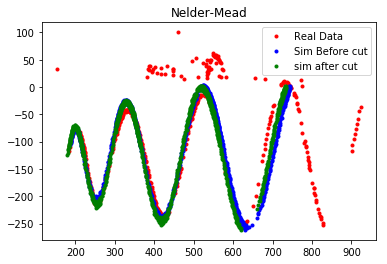

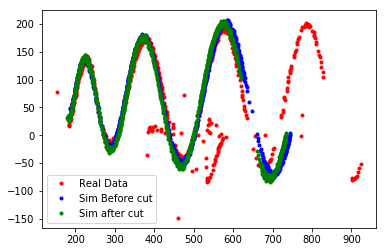

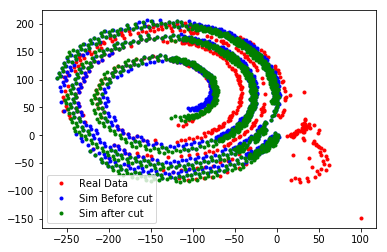

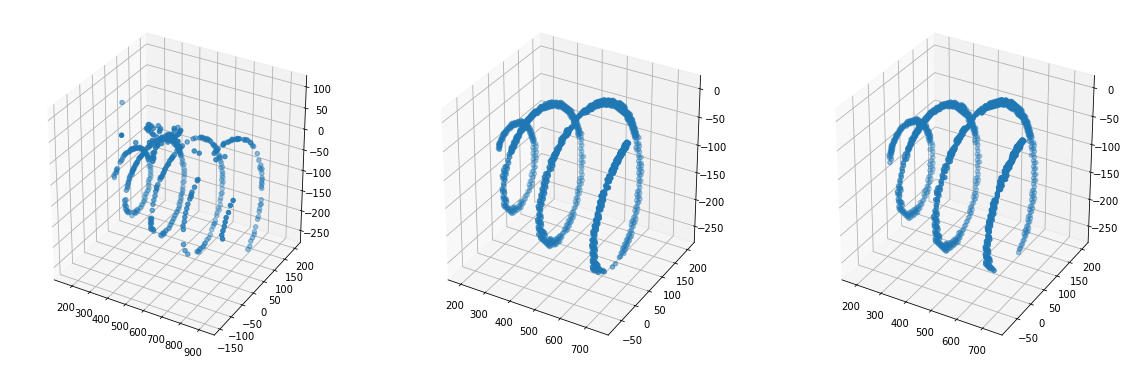

In [175]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.title("Nelder-Mead")
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

**Powell**

In [180]:
powell_results = scipy.optimize.minimize(f, ctr0, method="Powell", callback=callbackF)
powell = powell_results.x
print(powell_results)

 220 0.001650-0.000007 0.591235 2.466809-2.101898 2.771812 91.481648
 221 0.000886 0.003161 0.600142 2.470806-2.225069 2.771112 90.793716
 222 0.000104 0.002201 0.582091 2.505804-2.343694 2.770042 90.397080
 223 0.000103 0.001638 0.582043 2.659577-2.409238 2.770202 90.216256
 224 0.000103 0.001638 0.582043 2.899989-2.476043 2.783182 90.025872
 225 0.000046 0.001639 0.582042 4.533649-2.784799 2.840322 89.522668
 226 0.000053 0.001838 1.603915 4.559656-2.796275 2.822350 87.581292
 227-0.000801 0.001648 1.595368 4.577603-2.801732 2.811181 87.462785
 228-0.001176 0.001641 1.591529 4.577307-2.801606 2.806490 87.430197
 229-0.001148 0.001639 1.588538 4.570349-2.799669 2.805790 87.420098
 230-0.000426 0.001621 1.569327 4.472651-2.772609 2.801565 87.369590
 231 0.002217 0.001502 1.442600 3.740268-2.613196 2.777031 86.977774
 232 0.000691 0.001484 1.408492 3.477322-2.573925 2.767317 86.691405
 233 0.000907 0.001479 1.402739 3.431918-2.565790 2.766027 86.680246
 234 0.000905 0.001479 1.402713 3.

In [181]:
cut_powell_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="Powell", callback=cut_callbackF)
cut_powell = cut_powell_results.x
print(cut_powell_results)

 234 0.001703-0.000288 0.587759 2.389326-2.050539 2.738983 91.567917
 235 0.001598 0.002461 0.601203 2.374969-2.194108 2.757114 90.665452
 236 0.000220 0.001896 0.582078 2.408942-2.306730 2.757135 90.170209
 237 0.000187 0.001597 0.582043 2.561303-2.391427 2.769667 90.015575
 238-0.000237 0.001347 0.582042 2.818718-2.459836 2.781155 89.759848
 239 0.000296 0.001268 0.582042 3.007912-2.514293 2.785856 89.603839
 240 0.000304 0.001268 0.582042 3.154165-2.548000 2.793384 89.523472
 241 0.000312 0.001137 0.582042 3.275012-2.594722 2.796046 89.472367
 242 0.000091 0.000714 0.582042 3.934829-2.741861 2.812077 89.210580
 243-0.000101 0.001171 1.560450 4.367655-2.819323 2.811845 87.247551
 244-0.001541 0.001665 1.541877 4.303041-2.799038 2.804279 87.043916
 245-0.001541 0.001733 1.534376 4.243805-2.776830 2.803049 86.979497
 246-0.000181 0.002373 1.451079 3.669345-2.548750 2.782401 86.561154
 247-0.000072 0.001896 1.450640 3.734781-2.563839 2.780091 86.497495
 248-0.000012 0.001623 1.450390 3.

In [182]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(powell[0], powell[1], powell[2], powell[3], powell[4], powell[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_powell[0], cut_powell[1], cut_powell[2], cut_powell[3], cut_powell[4], cut_powell[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


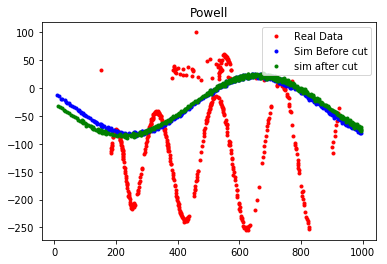

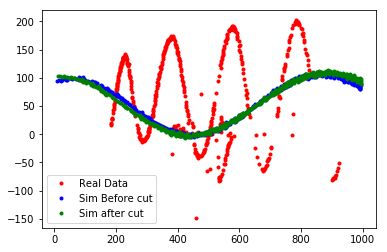

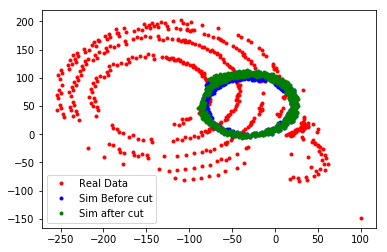

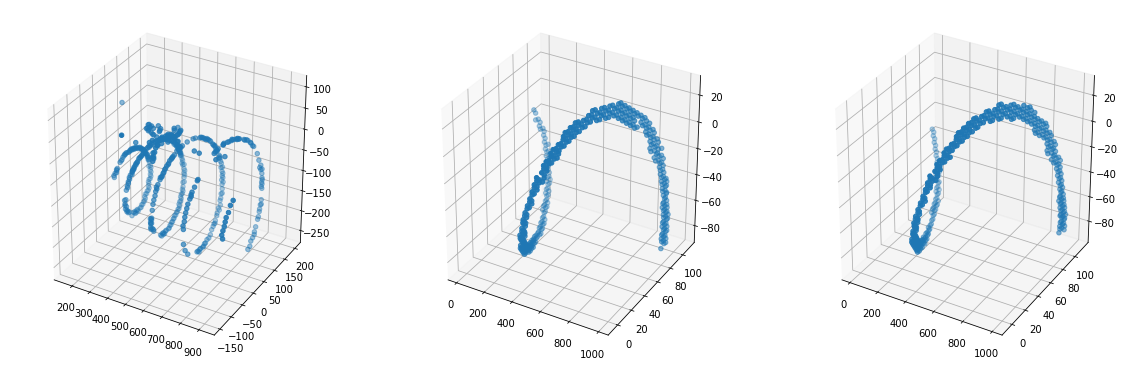

In [183]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.title("Powell")
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

**BFGS**

In [184]:
bfgs_results = scipy.optimize.minimize(f, ctr0, method="BFGS", callback=callbackF)
bfgs = bfgs_results.x
print(bfgs_results)

 235 0.004483 0.002190 0.699823 2.464538-2.050171 1.784320 98.133162
 236 0.002053 0.002472 0.676488 2.464814-2.049856 1.790353 94.271253
 237 0.002822 0.001606 0.674517 2.464875-2.049979 1.792721 94.061580
 238 0.002949 0.000727 0.674217 2.464817-2.049981 1.792523 94.031846
      fun: 94.03184628697413
 hess_inv: array([[ 4.03523430e-03, -2.07900655e-03,  8.74156710e-04,
         1.96806602e-02,  6.00873494e-02,  1.49140144e-03],
       [-2.07900655e-03,  1.65342249e-03, -2.04136498e-04,
         1.19223864e-02, -3.81656234e-02, -2.03601374e-03],
       [ 8.74156710e-04, -2.04136498e-04,  3.43717957e-04,
         1.34071276e-02,  9.90210755e-03, -1.54437451e-04],
       [ 1.96806602e-02,  1.19223864e-02,  1.34071276e-02,
         1.00143728e+00, -1.01959563e-03, -4.46869340e-02],
       [ 6.00873494e-02, -3.81656234e-02,  9.90210755e-03,
        -1.01959563e-03,  9.94147192e-01,  3.89859350e-02],
       [ 1.49140144e-03, -2.03601374e-03, -1.54437451e-04,
        -4.46869340e-02,  3.89

In [185]:
cut_bfgs_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="BFGS", callback=cut_callbackF)
cut_bfgs = cut_bfgs_results.x
print(cut_bfgs_results)

 249 0.004923 0.001482 0.698328 2.377413-2.050067 1.789917 98.801801
 250 0.000288 0.001736 0.686523 2.377724-2.049899 1.794040 96.094030
 251 0.000134 0.003479 0.686242 2.377824-2.050266 1.794694 96.090042
 252 0.005408 0.002978 0.688190 2.380488-2.063596 1.813716 91.288608
 253 0.002337 0.002423 0.685694 2.361739-2.096384 1.809347 91.189247
 254 0.001597 0.002276 0.685136 2.345732-2.108961 1.810333 91.053584
 255 0.001064 0.003632 0.694562 2.200629-2.170220 1.830632 87.988105
 256 0.001215 0.001898 0.701196 2.149854-2.223674 1.846401 86.875543
 257 0.009528-0.008128 0.730913 2.469100-2.219247 1.890191 75.858686
 258 0.009553-0.008040 0.731448 2.474453-2.217747 1.890957 75.692659
 259 0.008526-0.006880 0.730916 2.487914-2.212972 1.889252 74.185486
 260 0.006188-0.004529 0.730390 2.521026-2.207554 1.885068 71.464295
 261 0.001952-0.002051 0.726385 2.621774-2.194693 1.870793 67.003798
 262-0.005158 0.002424 0.722215 2.845339-2.181289 1.844372 60.543444
 263-0.004056 0.003702 0.724469 2.

In [186]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(bfgs[0], bfgs[1], bfgs[2], bfgs[3], bfgs[4], bfgs[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_bfgs[0], cut_bfgs[1], cut_bfgs[2], cut_bfgs[3], cut_bfgs[4], cut_bfgs[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


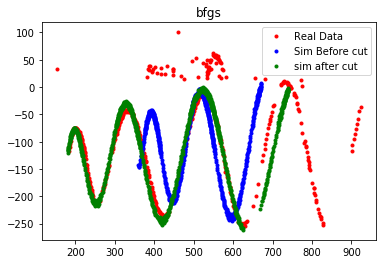

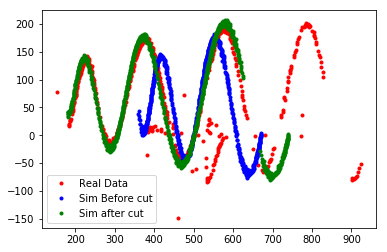

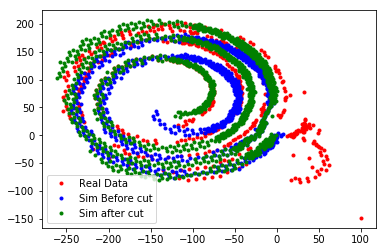

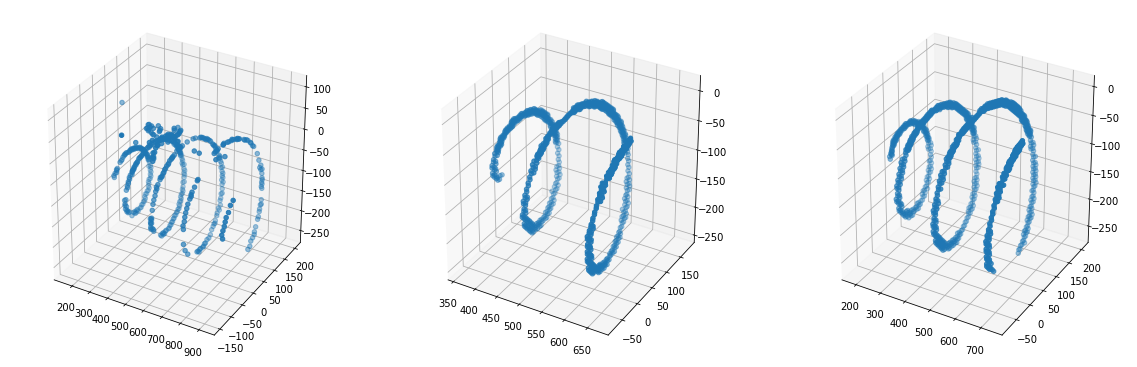

In [187]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.title("bfgs")
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

**Newton-Conjugate Gradient**

In [188]:
newton_results = scipy.optimize.minimize(f, ctr0, method="Newton-CG", jac=jacobian, callback=callbackF)
newton = newton_results.x
print(newton_results)

 239 0.001464 0.000715 0.713697 2.464549-2.050208 1.782631 98.932124
 240 0.001034 0.000497 0.709999 2.464556-2.050167 1.783286 98.299795
 241-0.003338-0.002522 0.696854 2.464763-2.049547 1.788419 96.112470
 242-0.009825-0.003561 0.703934 2.468607-2.055717 1.800477 94.342572
 243-0.004629 0.002471 0.704614 2.469003-2.055917 1.804372 92.214629
 244-0.005270 0.008859 0.726387 2.475335-2.058160 1.866856 76.407644
 245-0.004556 0.004166 0.726848 2.475595-2.058177 1.867527 75.546659
 246-0.004539 0.004160 0.726991 2.475624-2.058208 1.867465 75.535777
 247-0.004315 0.002036 0.730125 2.490933-2.063075 1.870004 75.062852
 248-0.004498 0.003616 0.729609 2.491192-2.063289 1.869875 75.019018
 249-0.002756 0.002779 0.727574 2.620991-2.058718 1.855499 72.285574
 250-0.002817 0.002809 0.726916 2.621046-2.058715 1.856105 71.903007
 251-0.002886 0.002937 0.726568 2.621091-2.058731 1.856535 71.679345
 252-0.005176 0.010676 0.731176 2.622535-2.060541 1.863527 69.531266
 253-0.004837 0.010357 0.730287 2.

In [189]:
cut_newton_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="Newton-CG", jac=cut_jacobian, callback=cut_callbackF)
cut_newton = cut_newton_results.x
print(cut_newton_results)

 269-0.012554 0.001248 0.701044 2.379899-2.050117 1.788909 98.308902
 270-0.003505-0.000043 0.701782 2.380294-2.049859 1.793435 96.176326
 271-0.003338 0.000532 0.708912 2.382586-2.048471 1.810317 93.978861
 272-0.003781 0.000736 0.706372 2.382720-2.048376 1.811864 92.653396
 273-0.005863 0.005708 0.707661 2.383600-2.048846 1.819208 90.792904
 274 0.001445 0.002912 0.728021 2.391351-2.054618 1.871332 78.074083
 275-0.002884 0.003051 0.726667 2.391534-2.054658 1.870427 77.042609
 276-0.002904 0.003082 0.726247 2.391573-2.054670 1.870507 76.998784
     fun: 76.99878442258765
     jac: array([ 14.2943964 , -12.18434048,  40.02493668, -10.59566116,
         8.33122349,  35.93254852])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 69
    nhev: 0
     nit: 8
    njev: 171
  status: 2
 success: False
       x: array([-0.00290409,  0.00308191,  0.72624697,  2.39157264, -2.05466967,
        1.87050684])


In [190]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(newton[0], newton[1], newton[2], newton[3], newton[4], newton[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_newton[0], cut_newton[1], cut_newton[2], cut_newton[3], cut_newton[4], cut_newton[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


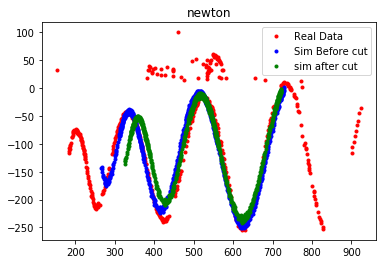

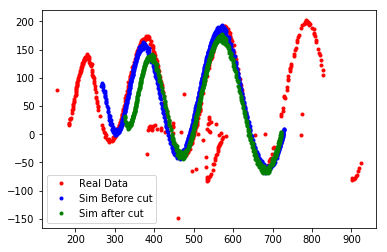

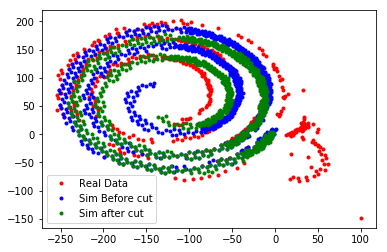

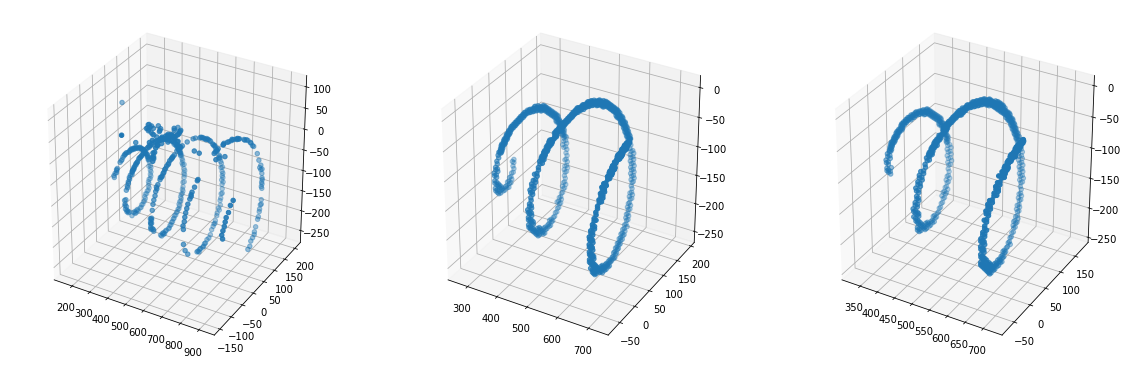

In [191]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.title("newton")
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

**L-BFGS-B**

In [192]:
l_bfgs_b_results = scipy.optimize.minimize(f, ctr0, method="L-BFGS-B", jac=jacobian, callback=callbackF)
l_bfgs_b = l_bfgs_b_results.x
print(l_bfgs_b_results)

 256 0.004279 0.002090 0.700758 2.464539-2.050174 1.784207 98.257184
 257 0.003599 0.002194 0.692148 2.464631-2.050051 1.786412 95.979914
 258-0.000054 0.005712 0.687485 2.464879-2.050519 1.788662 95.279808
 259-0.001688 0.004909 0.694640 2.464936-2.050829 1.788154 95.061515
 260-0.001189 0.005108 0.691925 2.465042-2.051025 1.789467 94.636095
 261-0.002386 0.005890 0.692653 2.465283-2.051561 1.791463 94.364626
 262-0.007327 0.008246 0.698046 2.466253-2.053715 1.799304 93.914125
 263-0.010385 0.009461 0.703078 2.467297-2.055908 1.808269 92.573962
 264-0.013045 0.010225 0.708644 2.468470-2.058319 1.818513 91.933203
 265-0.002611 0.008022 0.711183 2.470468-2.062916 1.835905 81.009907
 266-0.001141 0.007719 0.712122 2.470914-2.063923 1.839809 80.048458
 267 0.000352 0.005993 0.715616 2.471570-2.065380 1.845395 78.381815
 268 0.001190 0.002212 0.722165 2.472948-2.068231 1.856391 76.613145
 269-0.000061 0.000760 0.725372 2.473832-2.069832 1.862819 76.087355
 270-0.002248 0.001142 0.725238 2.

In [193]:
cut_l_bfgs_b_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="L-BFGS-B", jac=cut_jacobian, callback=cut_callbackF)
cut_l_bfgs_b = cut_l_bfgs_b_results.x
print(cut_l_bfgs_b_results)

 277 0.004959 0.001493 0.698165 2.377413-2.050066 1.789941 98.761569
 278 0.004196 0.001664 0.693396 2.377489-2.050011 1.791213 97.563745
 279-0.000675 0.003708 0.691904 2.377729-2.050259 1.792629 96.068919
 280-0.001661 0.004587 0.691328 2.377840-2.050417 1.793515 95.781928
 281-0.002828 0.006500 0.691662 2.378246-2.051189 1.796670 95.397165
 282-0.004602 0.009630 0.696053 2.379174-2.053069 1.803538 94.326065
 283-0.008965 0.015695 0.712676 2.383605-2.061702 1.837107 88.089153
 284-0.009687 0.016791 0.716013 2.384548-2.063532 1.844305 87.584594
 285-0.008940 0.014678 0.719329 2.385566-2.065509 1.851144 84.935139
 286-0.000193-0.000493 0.734035 2.392456-2.078192 1.891627 81.882930
 287-0.003588 0.005661 0.731154 2.390919-2.075368 1.882752 78.150281
 288-0.005358 0.007028 0.727460 2.389382-2.072361 1.872247 77.897603
 289-0.004886 0.005482 0.726714 2.389460-2.072390 1.871841 77.444546
 290-0.003792 0.001760 0.722164 2.388965-2.070937 1.864925 77.208970
 291-0.003386 0.002015 0.724202 2.

In [194]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(l_bfgs_b[0], l_bfgs_b[1], l_bfgs_b[2], l_bfgs_b[3], l_bfgs_b[4], l_bfgs_b[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_l_bfgs_b[0], cut_l_bfgs_b[1], cut_l_bfgs_b[2], cut_l_bfgs_b[3], cut_l_bfgs_b[4], cut_l_bfgs_b[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


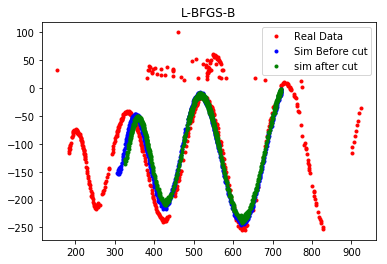

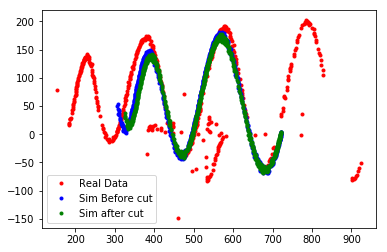

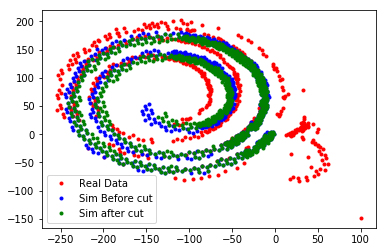

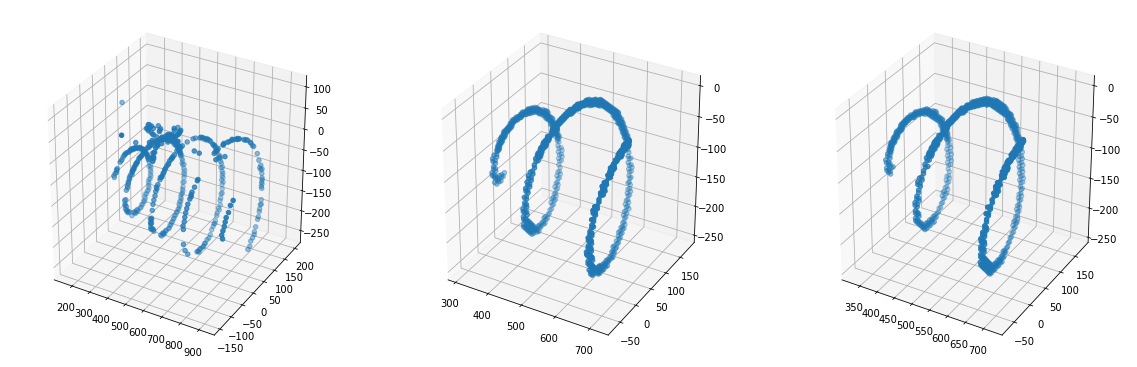

In [195]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.title("L-BFGS-B")
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

**TNC**

In [196]:
tnc_results = scipy.optimize.minimize(f, ctr0, method="TNC", jac=jacobian, callback=callbackF)
tnc = tnc_results.x
print(tnc_results)

 281 0.002945 0.001438 0.680368 2.464425-2.049897 1.794565 93.387780
 282 0.007304 0.001083 0.680056 2.458198-2.101947 1.795347 93.020478
 283 0.005760 0.000515 0.679247 2.456986-2.117466 1.796385 92.801537
 284 0.005584 0.000515 0.681137 2.456801-2.117778 1.795574 92.269482
 285-0.005515 0.007955 0.760990 2.457163-2.154338 1.914965 70.699158
 286-0.007389 0.007429 0.761707 2.457565-2.154141 1.916042 70.456785
 287-0.006696 0.002849 0.753130 2.462272-2.154472 1.906533 69.521797
 288-0.008061 0.002393 0.752769 2.462800-2.154778 1.906447 69.386700
 289-0.007774 0.002563 0.753598 2.462704-2.155074 1.907662 69.383043
 290-0.008178 0.002762 0.751914 2.462889-2.154643 1.906258 69.353932
     fun: 69.35393168814379
     jac: array([-50.04674339, -12.36304855, -31.71933842, -12.59975052,
         1.52087688,  41.26226234])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 10
  status: 3
 success: False
       x: array([-0.00817832,  0.00276178,  0.75191424,  2.462

In [198]:
cut_tnc_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="TNC", jac=cut_jacobian, callback=cut_callbackF)
cut_tnc = cut_tnc_results.x
print(cut_tnc_results)

 312-0.000597 0.003851 0.705496 2.366383-2.075098 1.730937 99.478502
 313 0.001731 0.003625 0.705509 2.366435-2.074988 1.731024 99.402413
 314 0.001263 0.000846 0.704861 2.366161-2.075325 1.729913 99.246827
 315 0.000940-0.000841 0.704914 2.366323-2.074765 1.730963 99.197254
 316 0.001204-0.000781 0.705021 2.365317-2.074624 1.731008 99.197106
 317 0.001207-0.000782 0.705021 2.365256-2.074406 1.731011 99.195981
 318 0.001207-0.000782 0.705021 2.365256-2.074406 1.731012 99.195968
 319 0.001191-0.000782 0.705013 2.365253-2.074403 1.731028 99.194593
     fun: 99.19459260691524
     jac: array([ 0.14301205,  0.18767834,  5.82705402,  2.04645538, -0.34737682,
       -5.10786629])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 8
  status: 3
 success: False
       x: array([ 1.19101700e-03, -7.81689692e-04,  7.05012848e-01,  2.36525294e+00,
       -2.07440335e+00,  1.73102753e+00])


In [199]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(tnc[0], tnc[1], tnc[2], tnc[3], tnc[4], tnc[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_tnc[0], cut_tnc[1], cut_tnc[2], cut_tnc[3], cut_tnc[4], cut_tnc[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


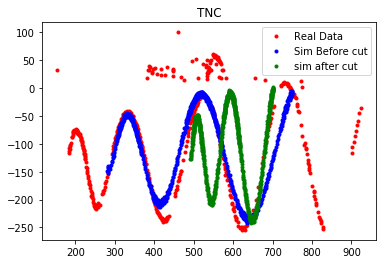

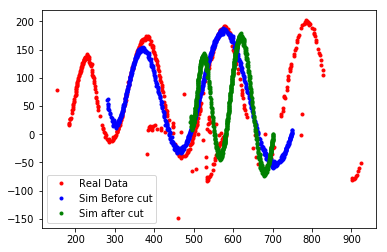

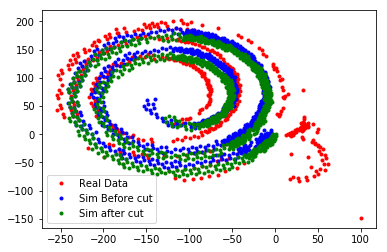

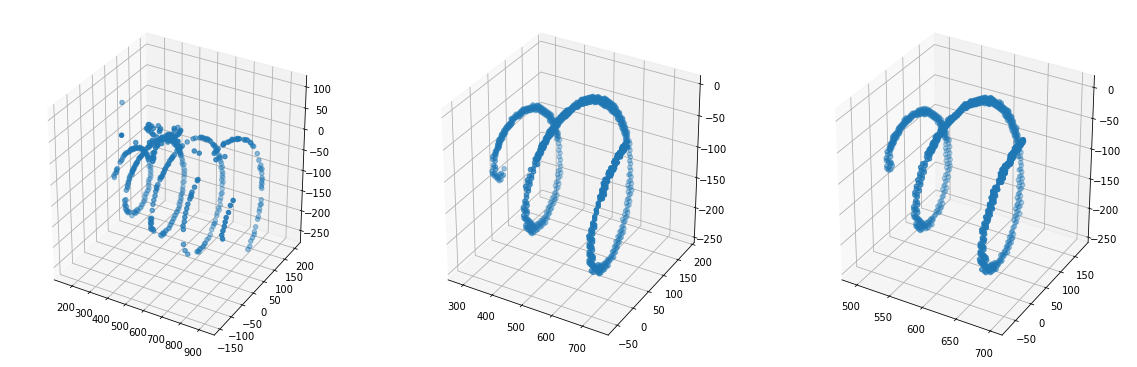

In [200]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.title("TNC")
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

**COBYLA**

In [201]:
cobyla_results = scipy.optimize.minimize(f, ctr0, method="COBYLA")
cobyla = cobyla_results.x
print(cobyla_results)

     fun: 91.32083883989772
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 91
  status: 1
 success: True
       x: array([-1.05590975e-03,  2.37685344e-03,  7.22574622e-01,  3.47417562e+00,
       -2.06015664e+00,  2.90156808e+00])


In [202]:
cut_cobyla_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="COBYLA")
cut_cobyla = cut_cobyla_results.x
print(cut_cobyla_results)

     fun: 91.17602411229397
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 93
  status: 1
 success: True
       x: array([-1.35765981e-03,  3.20733661e-03,  7.25799420e-01,  3.38376304e+00,
       -2.05637833e+00,  2.90159395e+00])


In [203]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(cobyla[0], cobyla[1], cobyla[2], cobyla[3], cobyla[4], cobyla[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_cobyla[0], cut_cobyla[1], cut_cobyla[2], cut_cobyla[3], cut_cobyla[4], cut_cobyla[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


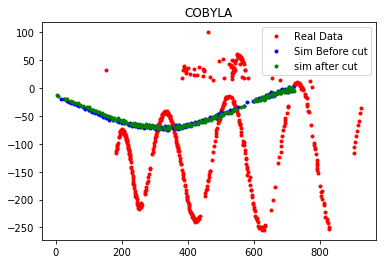

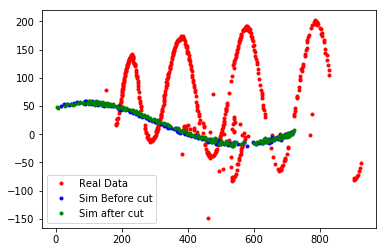

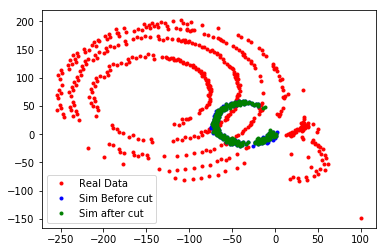

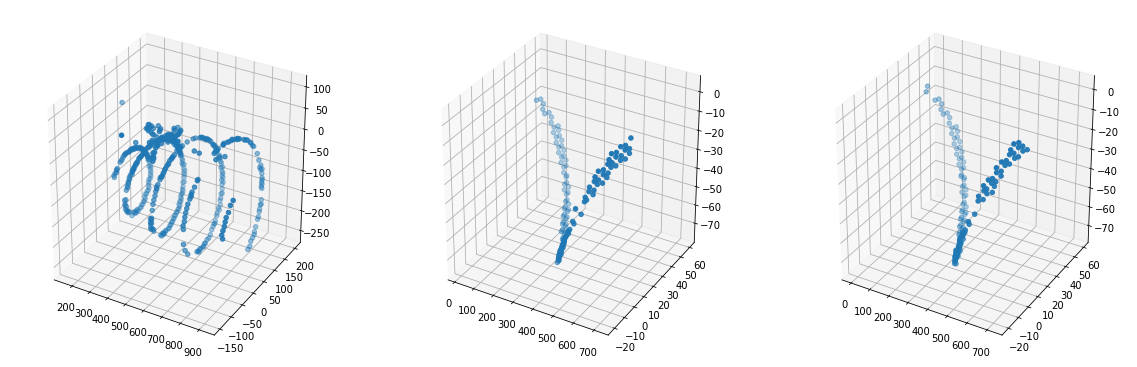

In [204]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.title("COBYLA")
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

**SLSQP**

In [205]:
slsqp_results = scipy.optimize.minimize(f, ctr0, method="SLSQP")
slsqp = slsqp_results.x
print(slsqp_results)

     fun: 46.56030081670766
     jac: array([ 8.53664102e+02, -3.04684830e+00,  1.68822389e+01,  4.98627472e+00,
        4.37086105e-01, -1.79569726e+01])
 message: 'Optimization terminated successfully.'
    nfev: 547
     nit: 54
    njev: 54
  status: 0
 success: True
       x: array([ 0.01345139,  0.00418498,  0.73369259,  3.21516845, -1.9878456 ,
        1.82546658])


In [206]:
cut_slsqp_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="SLSQP")
cut_slsqp = cut_slsqp_results.x
print(cut_slsqp_results)

     fun: 77.82158488198952
     jac: array([-3.48836613, -6.86028481,  2.63639355, -9.51607323, -0.04840183,
       -2.12534714])
 message: 'Optimization terminated successfully.'
    nfev: 206
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([-2.74925045e-03,  1.10871029e-03,  7.19142767e-01,  2.34380481e+00,
       -2.12589358e+00,  1.86296376e+00])


In [207]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(slsqp[0], slsqp[1], slsqp[2], slsqp[3], slsqp[4], slsqp[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_slsqp[0], cut_slsqp[1], cut_slsqp[2], cut_slsqp[3], cut_slsqp[4], cut_slsqp[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


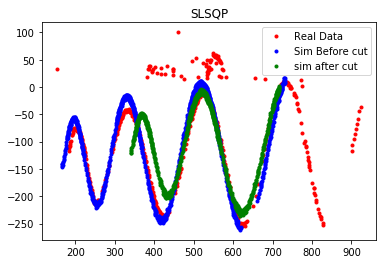

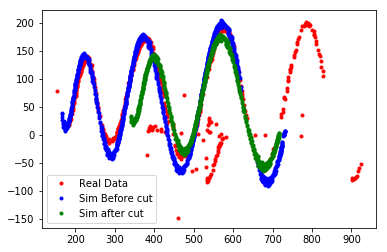

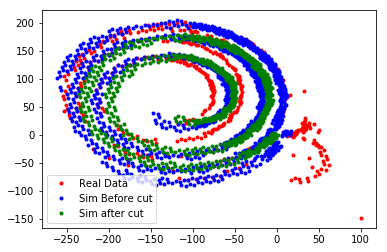

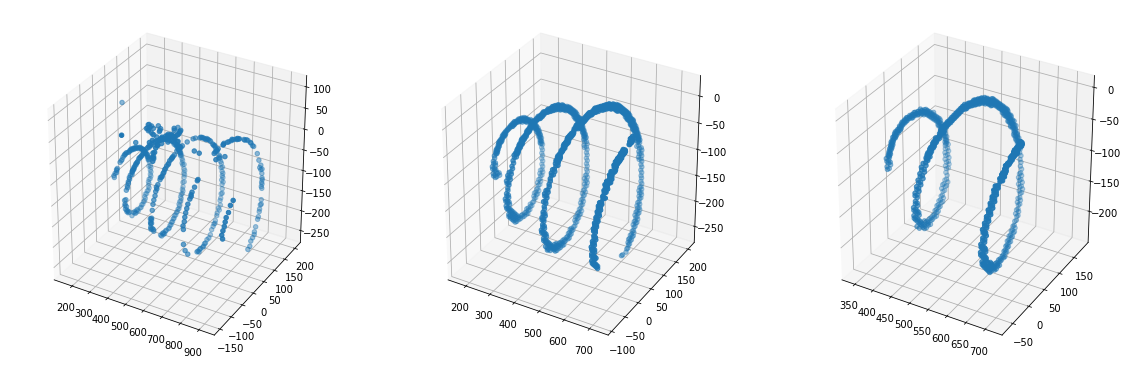

In [208]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.title("SLSQP")
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])